# Plot temperature response over time

## TODO:
- Aerosols inc BC on snow.
- Call it aerosols. 
- Assume addition normal distribution, independent. 

## Imports:

import numpy as np

In [28]:
import xarray as xr
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Paths input data

In [29]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

# PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
# PATH_DT = OUTPUT_DATA_DIR / '/dT_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'

#### Uncertainty data from Chris

In [30]:
PATH_DT_UNCERTAINTY = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris_ed02-3.nc'

## Set values:

In [31]:
first_y = '1750'
last_y = '2100'

**Set reference year for temperature change:**

In [32]:
ref_year = '2019'

In [33]:
FIGURE_DIR = RESULTS_DIR / 'figures_recommendation/'

TABLE_DIR = RESULTS_DIR / 'tables_recommendation/'

In [34]:
from pathlib import Path
Path(FIGURE_DIR).mkdir(parents=True, exist_ok=True)
Path(TABLE_DIR).mkdir(parents=True, exist_ok=True)

In [35]:
percentile = 'percentile'
climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [36]:
# variables to plot:
variables_erf_comp = [
    'aerosol-total-with_bc-snow',
    'ch4',
    # 'aerosol-radiation_interactions',
    # 'aerosol-cloud_interactions',
    #'aerosol-total',
    'o3',
    'HFCs',
    #'bc_on_snow'
]
# total ERFs for anthropogenic and total:
#variables_erf_tot = ['total_anthropogenic',
#                     'total']

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden'  # Due to mistake here
                    ]

### Scenarios:

In [37]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',
                'ssp334',
                'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                #'ssp370-lowNTCF-gidden',
                'ssp370-lowNTCF-gidden',
                'ssp585']

In [38]:
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [39]:
ds_DT = xr.open_dataset(PATH_DT)
ds_uncertainty = xr.open_dataset(PATH_DT_UNCERTAINTY)

In [40]:
ds_DT.scenario  # .climatemodel

<xarray.DataArray 'scenario' (scenario: 11)>
array(['ssp534-over', 'ssp334', 'ssp119', 'ssp460', 'ssp585', 'ssp370',
       'ssp370-lowNTCF-aerchemmip', 'ssp126', 'ssp245', 'ssp434',
       'ssp370-lowNTCF-gidden'], dtype=object)
Coordinates:
  * scenario  (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-gidden'

In [41]:
ds_DT['variable']

<xarray.DataArray 'variable' (variable: 19)>
array(['co2', 'ch4', 'n2o', 'other_wmghg', 'o3', 'h2o_stratospheric',
       'contrails', 'aerosol-radiation_interactions',
       'aerosol-cloud_interactions', 'bc_on_snow', 'land_use', 'volcanic',
       'solar', 'total_anthropogenic', 'total_natural', 'total',
       'aerosol-total', 'aerosol-total-with_bc-snow', 'HFCs'], dtype=object)
Coordinates:
  * variable  (variable) object 'co2' 'ch4' ... 'HFCs'

In [42]:
ds_uncertainty['variable']

<xarray.DataArray 'variable' (variable: 8)>
array(['HFCs', 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)', 'aerosol-total',
       'bc_on_snow', 'ch4', 'o3', 'total_anthropogenic',
       'aerosol-total-with_bc-snow'], dtype=object)
Coordinates:
  * variable  (variable) object 'HFCs' ... 'aerosol-total-with_bc-snow'

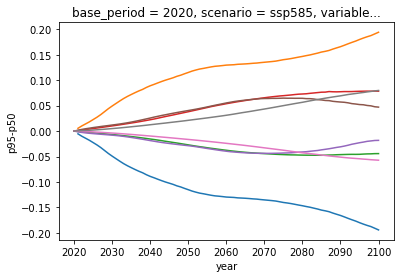

In [43]:
for var in variables_erf_comp:
    da5 = ds_uncertainty.sel(variable=var, scenario='ssp585')['p05-p50']    
    da95 = ds_uncertainty.sel(variable=var, scenario='ssp585')['p95-p50']
    da5.plot(label=var)
    da95.plot(label=var)








In [44]:
from ar6_ch6_rcmipfigs.utils.plot import get_var_nicename

In [45]:
name_deltaT = 'Delta T'

## Plot $\Delta T$ from ref year:

In [46]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic, get_ls_dic, trans_scen2plotlabel, get_scenario_c_dic, \
    get_scenario_ls_dic
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel
import numpy as np

In [382]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic, \
    get_scenario_ls_dic


def get_fig_ax_tot(fgsize=None, nrows=2, ncols=3, rows_tot=0, cols_tot=2, tot_first=True, orientation='horizontal'):
    """
    Makes figure for total plot
    :param orientation: horizontal or vertical
    :param tot_first: plot with total comes first or second
    :param cols_tot:
    :param rows_tot:
    :param ncols:
    :param nrows:
    :param fgsize:
    :return:
    """
    if fgsize is None:
        fgsize = [11, 4.4]
    fg = plt.figure(constrained_layout=False, figsize=fgsize, dpi=150)
    if orientation == 'horizontal':
        _cols = ncols + cols_tot
        _rows = nrows
    else:
        _cols = ncols  # + cols_tot
        _rows = nrows + rows_tot

    spec2 = gridspec.GridSpec(ncols=_cols, nrows=_rows, figure=fg)
    com_axs = []
    if tot_first:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, 0:cols_tot])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, cols_tot + j]))
        else:

            all_ax = fg.add_subplot(spec2[0:rows_tot, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[rows_tot + i, j]))
    else:
        if orientation == 'horizontal':
            all_ax = fg.add_subplot(spec2[:, (-cols_tot):])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))
        else:

            all_ax = fg.add_subplot(spec2[(-rows_tot):, :])
            for i in np.arange(nrows):
                for j in np.arange(ncols):
                    com_axs.append(fg.add_subplot(spec2[i, j]))

    return fg, com_axs, all_ax


def get_fig_ax_tot_old(fgsize=None):
    """
    Makes figure for total plot
    :param fgsize:
    :return:
    """
    if fgsize is None:
        fgsize = [13, 12]
    _fig = plt.figure(constrained_layout=False, figsize=fgsize, dpi=140)
    spec2 = gridspec.GridSpec(ncols=12, nrows=4, figure=_fig)
    com_axs = []
    for i in np.arange(2):
        for j in np.arange(3):
            if i == 1 and j == 2: continue
            com_axs.append(_fig.add_subplot(spec2[i, j * 4:(j + 1) * 4]))
    all_ax = _fig.add_subplot(spec2[2:, 2:10])
    return _fig, com_axs, all_ax


def fix_ax(_ax):
    # ls = pd.date_range('2010-1-1', periods=100, freq='Y')[0::10]
    # ax.set_xticks(list(ls))
    # ax.set_xlim(s_y2, e_y2)  # '2015','2100')
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    return


def fign_dt(_var, _s_y, _e_y):
    return '%s_refy%s_fy%s.png' % (_var.replace(' ', '_').replace('|', '-'), _s_y, _e_y)

In [48]:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl: 
    _str += f'{var}, '

# ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])


vn_sum = 'Sum SLCF (%s)' % _str[:-2]
print(vn_sum)
#_st = vn_sum.replace('(','').replace(')','').replace(' ','_').replace(',','')+'.csv'

_da_sum  = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable)
#_da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(year=slice(int(s_y2), int(e_y2))) - ds_DT_sy
_da_sum#.assin_coord()
#_ds_check = ds_DT.copy()
ds_DT
#xr.concat([_ds_check[name_deltaT],_da_sum], dim=variable)

dd1=_da_sum.expand_dims(
    {'variable':
    [vn_sum]})
#dd1=dd1.to_dataset()

ds_DT = xr.merge([ds_DT,dd1])

Sum SLCF (Aerosols, Methane, Ozone, HFCs)


In [380]:
def add_uncertainty_bar(ax, var, end_y = 2100, s_y = 2019,
                        to = 'p95-p50', 
                        frm='p05-p50',
                       linewidth=4,
                       i_plus = 1.5,
                        alpha = 1
                       ):
    _ds2100_err = ds_uncertainty.sel(year=end_y)
    _ds2100 = ds_DT.sel(year=end_y)-ds_DT.sel(year=s_y)
    #var = 'Sum SLCF (Methane, Aerosols, Ozone, HFCs)'
    #to = 'p95-p50'
    #frm = 'p05-p50'
    #_ds2100_err.sel(variable=var)
    i= end_y+1# 2101
    ax.set_xlim([2015,2100])
    #print(_ds2100.sel(scenario=scenarios_fl))
    for scn in scenarios_fl:
        _ds2100_err_scn = _ds2100_err.sel(scenario=scn, variable=var)
        _ds2100_scn = _ds2100.sel(scenario=scn, variable=var) 
        bot =float(-_ds2100_err_scn[frm])
        top = float(_ds2100_err_scn[to])

        mid = float(_ds2100_scn[name_deltaT])
        er = np.array([[bot,top],]).transpose()
        eb1 = ax.errorbar(i,mid, yerr=er ,c= cdic[scn], 
                      linestyle=lsdic[scn], linewidth=linewidth, 
                      alpha=alpha, zorder=100, clip_on=True,)
        #ax.scatter([i], [mid],c=cdic[scn],marker = '*',clip_on=False, zorder=100)
        i+=i_plus
        eb1[-1][0].set_linestyle(lsdic[scn])
        eb1[-1][0].set_clip_on(False)
    #linestyle=lsdic[scn], linewidth=linewidth
    #plt.tight_layout()
    #ax.set_xticks([2020,2040,2060,2080,2100])



In [50]:
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

In [337]:
from matplotlib import ticker


In [424]:
ls_xticks= [2020,2040,2060,2080,2100]

aerosol-total-with_bc-snow
[-0.7846905249099848, 0.14584390855816487]
-0.6359533648931909
ch4
[0.05612469446816759, 0.7449512366459158]
0.3156058964098794
o3
[-0.02398712943159831, 0.6741130935527841]
0.2686402660416958
HFCs
[-0.005335516062570829, 0.33790171035508687]
0.014184405514064323
[-0.1682725951982837, 1.262045106340271]
-0.03752279692755127


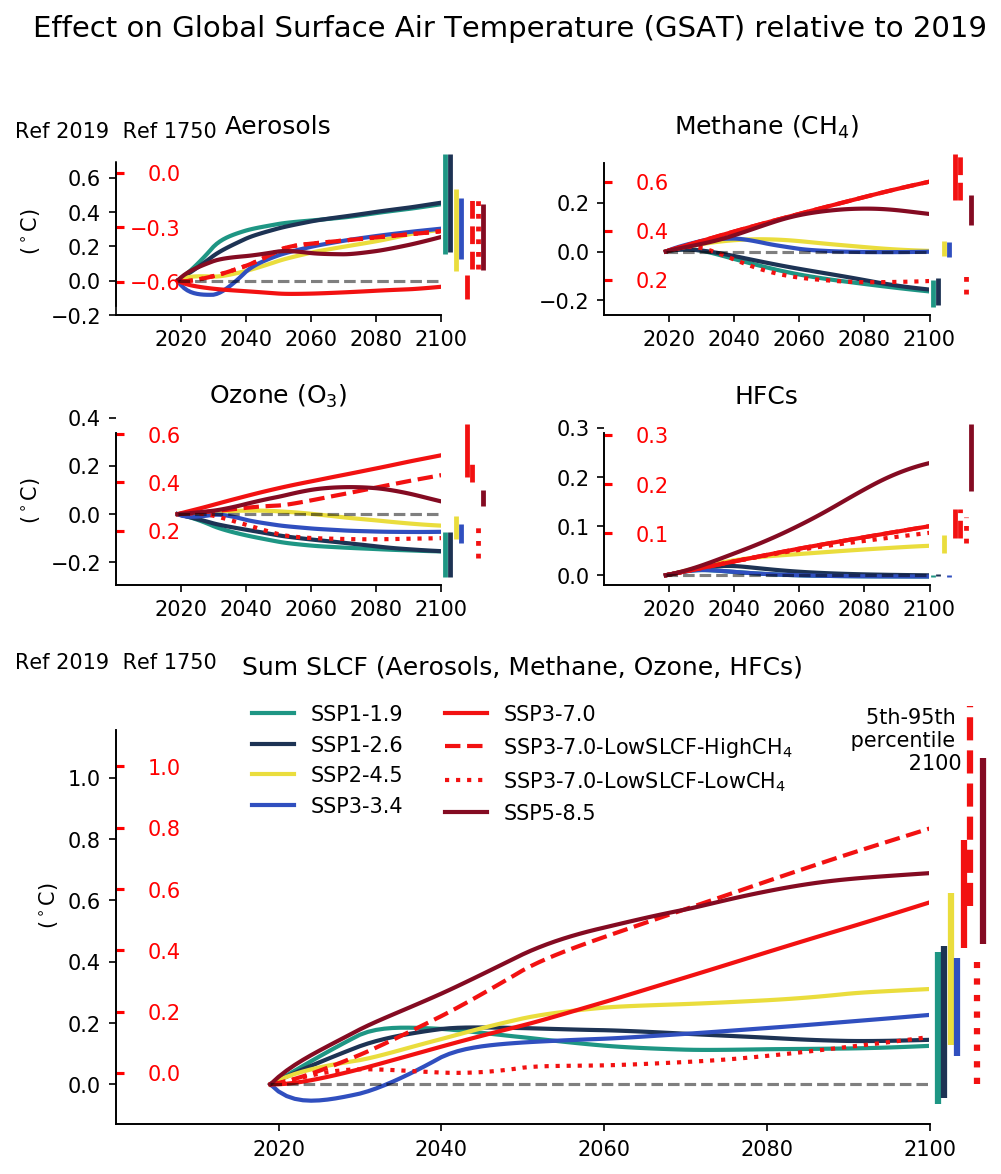

In [427]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel

# get_fig_ax_tot

import matplotlib.pyplot as plt

figsize = [7, 8]#[6, 4]
s_y = ref_year
s_y2 = '2019'
s_y2_xax = '2005'

e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

linewidth = 2

fig2, axs, ax_tot = get_fig_ax_tot(fgsize=figsize, rows_tot=2, cols_tot=0,ncols=2,
                                   orientation='vertical',
                                   tot_first=False)

# fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
twn_axs =[]
for var, ax in zip(variables_erf_comp, axs):

    print(var)

    # fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in scenarios_fl:# list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2))
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        # Choose median: 
        _pl_da = _da.sel(percentile=recommendation)
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))

    ax.set_xlabel('')
    ax.set_ylabel('')
    # Plot zero line:
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    add_uncertainty_bar(ax, var, linewidth=2.3, i_plus=1.7)
    #ax.set_ylim([-.3,1])
    par1 = ax.twinx()
    add_ticks_rigth(par1)
    fix_ax(ax)
    fix_ax(par1)
    #ax.spines['bottom'].set_bounds(2019, 2100)
    #par1.spines['bottom'].set_bounds(2019, 2100)
    bound_yax(ax)
    bound_yax(par1)
    ax.set_xlim([2000,2100])
    twn_axs.append(par1)
    set_ylim_sec_ax(ds_DT, var, ax, par1,ref_year=1750, ref_y_first_ax=2019) 
    #ax.set_yticks(ax.get_yticks()[:-1])
    #par1.set_yticks(par1.get_yticks()[:-1])
    par1.set_yticks(ytick_dic_pi[var])
    ax.set_yticks(ytick_dic[var])
    ax.set_xticks(ls_xticks)

add_reftext(axs[0])
    
    
for ax in axs[0::2]:
    ax.set_ylabel('($^\circ$C)')
    
    
if len(axs)>len(variables_erf_comp):
    l = len(variables_erf_comp)
    for i in range(l,len(axs)):
        axs[l].axis('off')
        
# Total:

ax = ax_tot

cdic = get_scenario_c_dic()
# for var in variables_erf_tot:  # , f_totn]:
for scn in scenarios_fl:#list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                     year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile=recommendation)
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), linestyle=lsdic[scn], linewidth=linewidth)

    
var = 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'

add_uncertainty_bar(ax, var, linewidth=3,
                    i_plus=.8)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
plt.suptitle('Effect on Global Surface Air Temperature (GSAT) relative to 2019', fontsize=14, y=1.05)
# adjust plot visuals:
_str = ''
_vl = [get_var_nicename(var).split('(')[0].strip() for var in variables_erf_comp]
for var in _vl: _str += f'{var}, '
# ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])
ax.set_title('Sum SLCF (%s)' % _str[:-2])
# ax.set_ylabel('$\Delta$ T ($^\circ$C)')
ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

par1 = ax.twinx()
add_ticks_rigth(par1)
fix_ax(ax)
fix_ax(par1)
fix_ax(ax)

#ax.spines['bottom'].set_bounds(2019, 2100)
#par1.spines['bottom'].set_bounds(2019, 2100)
ax.set_xlim([2000,2100])
add_reftext(ax)
ax.text(1.04,.8,
            '5th-95th \n percentile \n 2100',
            ha='right',
            va='bottom',
            transform = ax.transAxes)
var = 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'

diff =set_ylim_sec_ax(ds_DT, var, ax, par1,ref_year=1750, ref_y_first_ax=2019) 
#ax.set_yticks(ax.get_yticks()[:-2])
#par1.set_yticks(par1.get_yticks()[:-2])
ax.set_yticks(ytick_dic[var])
ax.set_xticks(ls_xticks)

#ax.set_yticks(ytick_dic[var])

par1.set_yticks(ytick_dic_pi[var])

ax.legend(frameon=False, loc='upper center',ncol=2)
plt.subplots_adjust(top=0.94, left=0.125, wspace=.5, hspace=.6)
#plt.tight_layout()# w_pad=4)#rect=[0,0,.94,1],
plt.savefig(FIGURE_DIR / 'total_ref2019_from2015_all_2.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURE_DIR / 'total_ref2019_from2015_all_2.pdf', bbox_inches='tight')  # , dpi=300)
plt.show()

In [420]:
ytick_dic = {
    'aerosol-total-with_bc-snow': [-.2,.0,.2,.4,.6],
    'ch4': [-0.2,0,.2],#,.4],
    'o3': [-.2,0.,.2,.4],#,.6],
    'HFCs': [0,.1,.2,.3],
    'Sum SLCF (Aerosols, Methane, Ozone, HFCs)': [0,.2,.4,.6,.8,1]
}

In [402]:
diff

-0.03752279692755127

In [388]:
ytick_dic_pi[var]

[0.1, 0.2, 0.3]

In [389]:
var

'HFCs'

In [326]:
ax.get_yticks()[ax.get_yticks()<0.9]

array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8])

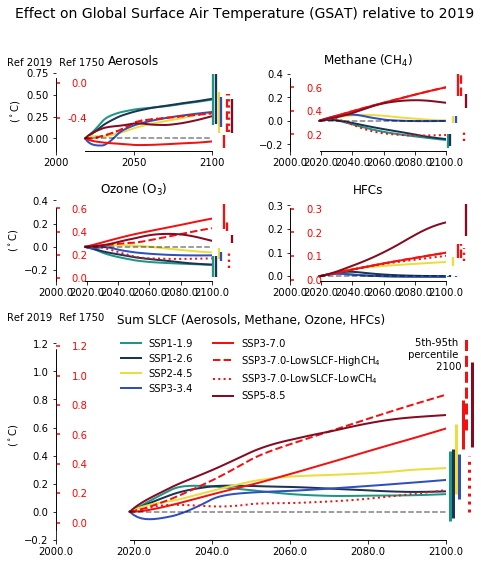

In [356]:
ax.set_yticks(ax.get_yticks()[:-1])#[:-1])
fig2

In [344]:
print('%.0f'%23.555)

24


In [373]:
variables_erf_comp

['aerosol-total-with_bc-snow', 'ch4', 'o3', 'HFCs']

In [386]:
ytick_dic_pi = {
    'aerosol-total-with_bc-snow': [-.6, -.3,0.],
    'ch4': [0.2,.4,.6],
    'o3': [.2,.4,.6],
    'HFCs': [.1,.2,.3],
    'Sum SLCF (Aerosols, Methane, Ozone, HFCs)': [0,.2,.4,.6,.8,1]
}


[-0.6 -0.3  0. ]


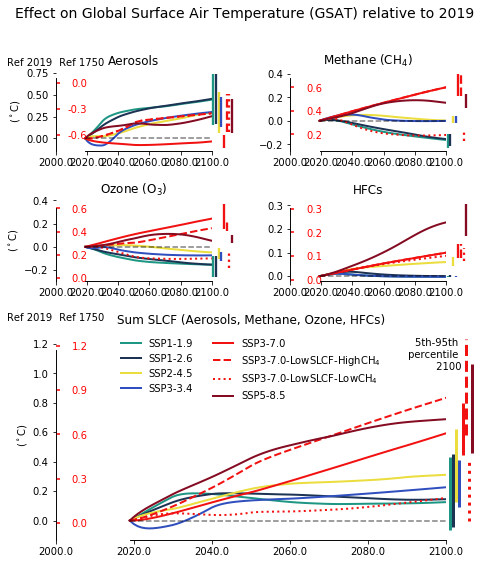

In [376]:
twn_axs[0].caxis.set_major_formatter(ticker.StrMethodFormatter("{x:.01f}"))
#twn_axs[0].yaxis.set_major_locator(plt.)
twn_axs[0].set_yticks([-.6, -.3,0.])
print(twn_axs[0].get_yticks())
fig2


In [397]:
diff

-0.03752279692755127

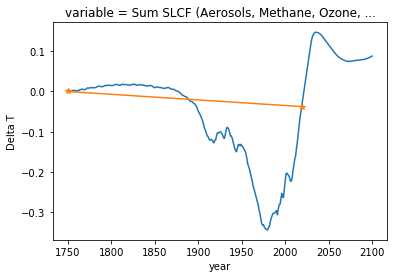

In [412]:
ds_DT.sel(variable=var, scenario='ssp119').squeeze()[name_deltaT].plot.line()

ds_DT.sel(variable=var, scenario='ssp585', year=[1750,2019]).squeeze()[name_deltaT].plot.line(marker='*')


In [413]:
ds_DT.sel(variable=var, scenario='ssp585', year=[1750,2019]).squeeze()[name_deltaT]

<xarray.DataArray 'Delta T' (year: 2)>
array([ 0.       , -0.0375228])
Coordinates:
    variable    <U41 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'
  * year        (year) int64 1750 2019
    scenario    <U6 'ssp585'
    percentile  <U14 'recommendation'

In [407]:
var
se_da = ds_DT.sel(variable=var).squeeze()[name_deltaT]

difference_y1_y2 =(se_da.sel(year=2019)-se_da.sel(year=1750)).mean('scenario')
difference_y1_y2 = float(difference_y1_y2)
difference_y1_y2

-0.03752279692755127

In [280]:
se_da = ds_DT.sel(variable=variables_erf_comp[0]).squeeze()[name_deltaT]
(se_da.sel(year=2019)-se_da.sel(year=1750)).mean('scenario')

<xarray.DataArray 'Delta T' ()>
array(-0.63595336)
Coordinates:
    variable    <U26 'aerosol-total-with_bc-snow'
    percentile  <U14 'recommendation'

In [426]:
def set_ylim_sec_ax(ds_dT, var, ax1, ax2,ref_year=1750, ref_y_first_ax=2019):
    ylims = ax1.get_ylim()
    # as long as both ref_year and ref_y_first_ax are in historical period, all scenarios are the same:
    se_da = ds_DT.sel(variable=var).squeeze()[name_deltaT]

    difference_y1_y2 =(se_da.sel(year=2019)-se_da.sel(year=1750)).mean('scenario')
    difference_y1_y2 = float(difference_y1_y2)
    print([ylims[0]+difference_y1_y2, ylims[1]+difference_y1_y2])
    ax2.set_ylim([ylims[0]+difference_y1_y2, ylims[1]+difference_y1_y2])
    bound_yax(ax1, red_ybound=.1)
    bound_yax(ax2, red_ybound=.1)
    
    print(difference_y1_y2)
    return difference_y1_y2

In [332]:
def add_reftext(ax, y_pos=1.03):
    ax.text(-0.,y_pos,
            'Ref 2019 ',
            ha='right',
            va='bottom',
            transform = ax.transAxes)
    ax.text(-0.,y_pos,
            ' Ref 1750',
            ha='left',
            va='bottom',
            transform = ax.transAxes)
def bound_yax(ax, red_ybound=.1):
    bounds = ax.get_ybound()#[0]
    to = bounds[1]
    bo = bounds[0]
    ax.spines['left'].set_bounds(low =bo ,high=(to-(to-bo)*red_ybound))


In [154]:
axs[0::2]

In [77]:
ds_DT[name_deltaT].sel(variable='o3', scenario='ssp119', year=2019)

<xarray.DataArray 'Delta T' (percentile: 1)>
array([0.26864027])
Coordinates:
    variable    <U2 'o3'
    year        int64 2019
    scenario    <U6 'ssp119'
  * percentile  (percentile) object 'recommendation'

In [422]:
def add_ticks_rigth(par1, c='r', tkw=dict(size=4, width=1.5)):
    par1.tick_params(axis='y', direction='in')
    par1.yaxis.label.set_color(c)

    
    #par1.spines["left"].set_position(("axes", -0.)) # red one

    #make_patch_spines_invisible(par1)

    par1.spines["left"].set_visible(True)
    par1.yaxis.set_label_position('left')
    par1.yaxis.set_ticks_position('left')


    par1.tick_params(axis="y",direction="in", 
                     pad=-31, 
                     right=False, 
                     left=True,
                     top=False, 
                     colors=c, 
                     **tkw,
                )
    #par1.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))



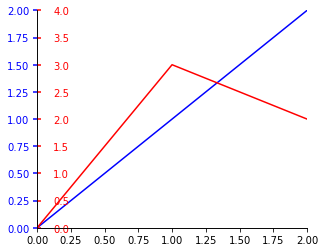

In [303]:
import matplotlib.pyplot as plt


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()

p1, = host.plot([0, 1, 2], [0, 1, 2], "b-", label="Density")
p2, = par1.plot([0, 1, 2], [0, 3, 2], "r-", label="Temperature")
#p3, = par2.plot([0, 1, 2], [50, 30, 15], "g-", label="Velocity")

host.set_xlim(0, 2)
host.set_ylim(0, 2)
par1.set_ylim(0, 4)


host.yaxis.label.set_color(p1.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)

lines = [p1, p2, p3]


    
add_ticks_rigth(par1)
par1.spines['right'].set_visible(False)
par1.spines['top'].set_visible(False)
host.spines['right'].set_visible(False)
host.spines['top'].set_visible(False)

host

In [25]:
import seaborn as sns

In [26]:
ax.get_ylim()

(-0.132326117589722, 1.2843438365130897)

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.6, pack_start=False)
fig2.add_axes(cax, frameon=False)
sns.despine(ax = cax, left=True, right=True, bottom=True, top=True)

cax.set_ylim(ax.get_ylim())
cax.axis('off')

(0.0, 1.0, -0.132326117589722, 1.2843438365130897)

aerosol-total-with_bc-snow


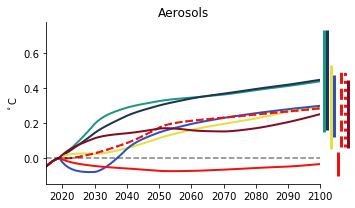

ch4


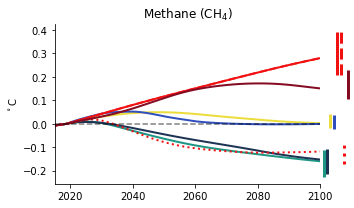

o3


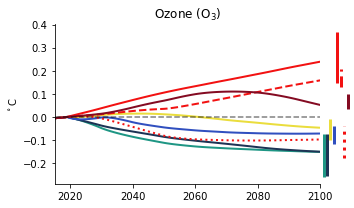

HFCs


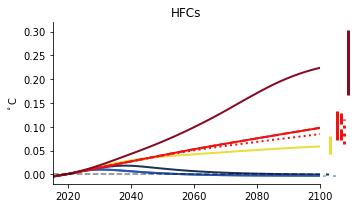

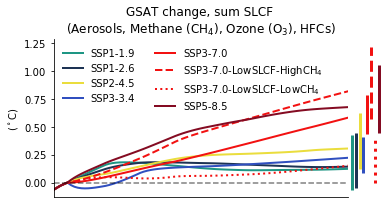

In [28]:
from ar6_ch6_rcmipfigs.utils.plot import trans_scen2plotlabel


# get_fig_ax_tot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ar6_ch6_rcmipfigs.utils.misc_func import make_folders

figsize = [5, 3]
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

linewidth = 2

# fig2, axs, ax_tot = get_fig_ax_tot()#fig3 = plt.figure(constrained_layout=True)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
for var in variables_erf_comp:  # , axs):

    print(var)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in scenarios_fl:#list(set(scenarios_fl) - {'historical'}):
        # compute difference from ref year:
        _da_ally = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2))
        _da_refy = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y, s_y)).squeeze()
        _da = _da_ally - _da_refy
        # Choose median: 
        _pl_da = _da.sel(percentile=recommendation)
        # Plot mean: 
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=linewidth)

    # various labels:
    ax.set_title('%s' % get_var_nicename(var))
    ax.set_ylabel('$^\circ$C')
    ax.set_xlabel('')
    fix_ax(ax)
    # Plot zero line:
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    # figname
    fign = FIGURE_DIR / fign_dt(var, s_y, s_y2)
    make_folders(str(fign))
    #add_uncertainty_bar(ax, var, )
    add_uncertainty_bar(ax, var, linewidth=3, i_plus=1.1)


    plt.tight_layout()
    fig.subplots_adjust(right=.9) # or whatever

    plt.savefig(fign, dpi=300)
    plt.savefig(fign.with_suffix('.pdf'))  
    plt.show()

axs[0].set_ylabel('($^\circ$C)')
for ax in axs:
    # ax.set_ylabel('Change in temperature (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')

fig, ax = plt.subplots(1, 1, figsize=figsize)  # [9,5])

cdic = get_scenario_c_dic()
# for var in variables_erf_tot:  # , f_totn]:
for scn in scenarios_fl:#list(set(scenarios_fl) - {'historical'}):
    # Plot dataset difference to first year, i.e.
    ds_DT_sy = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                     year=slice(s_y, s_y)).squeeze()
    _da = ds_DT[name_deltaT].sel(variable=variables_erf_comp).sum(variable).sel(scenario=scn,
                                                                                year=slice(s_y2, e_y2)) - ds_DT_sy
    # Take median::
    _pl_da = _da.sel(percentile=recommendation)
    _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle=lsdic[scn],
                linewidth=linewidth)
var = 'Sum SLCF (Aerosols, Methane, Ozone, HFCs)'

add_uncertainty_bar(ax, var, linewidth=3, i_plus=1.1)

# adjust plot visuals:
_str = ''
for var in ds_DT.sel(variable=variables_erf_comp)[variable].values: _str += f'{get_var_nicename(var)}, '
ax.set_title('GSAT change, sum SLCF \n(%s)' % _str[:-2])

ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2, ncol=2)
fix_ax(ax)
_ds = ds_DT.sel(year=slice(s_y2, e_y2))
ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')

plt.tight_layout()
fn = FIGURE_DIR / fign_dt('total', s_y, s_y2)
plt.savefig(fn, dpi=200)
plt.savefig(fn.with_suffix('.pdf'))  # , dpi=200)
plt.show()

# Supplementary plots:

## Plot $\Delta$ T and ERF with reference year +/- 1 standard deviation of the models

In [29]:
scenarios_fl=['ssp119',
 'ssp126',
 'ssp245',
              
# 'ssp370',
 'ssp370-lowNTCF-aerchemmip',
 'ssp370-lowNTCF-gidden',
 'ssp585']

In [30]:
ref_year

'2019'

aerosol-total-with_bc-snow


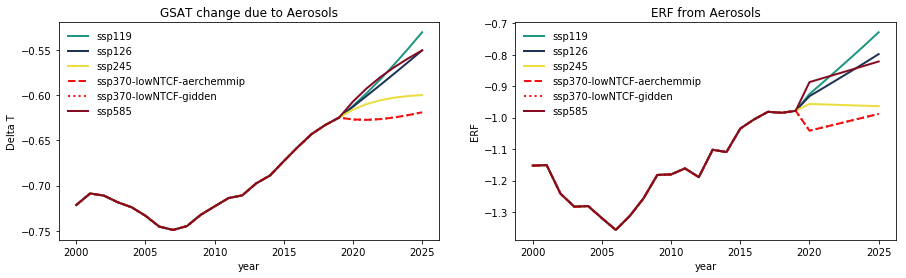

ch4


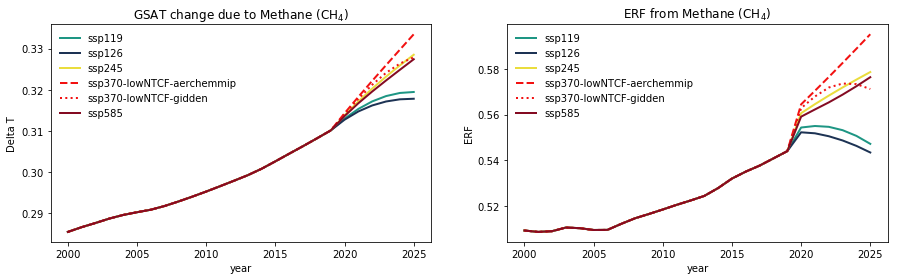

o3


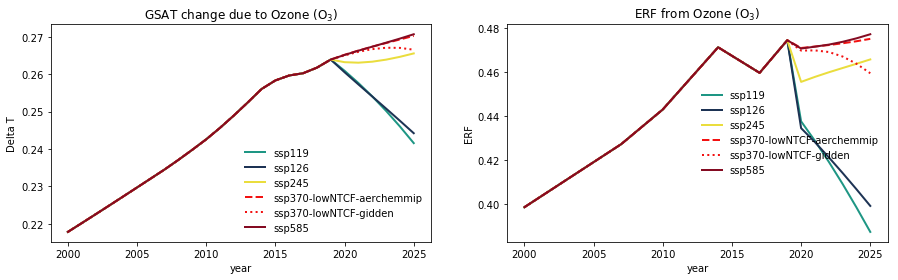

HFCs


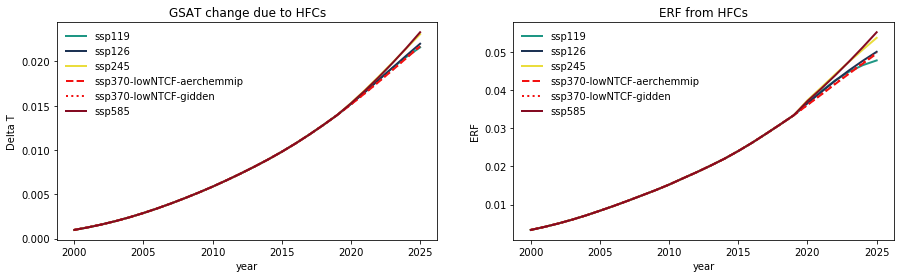

In [31]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)
s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True

        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(2000,2025)).sel(percentile=recommendation)
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(2000,2025))
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()

Subtracting year 2019, while still plotting from 2015. Thus the results represent the cooling/warming with respect to year 2020

aerosol-total-with_bc-snow


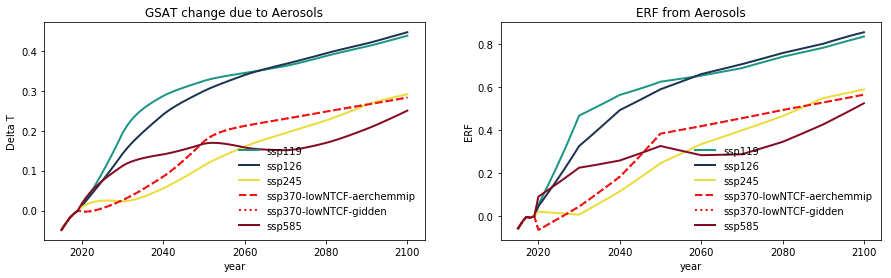

ch4


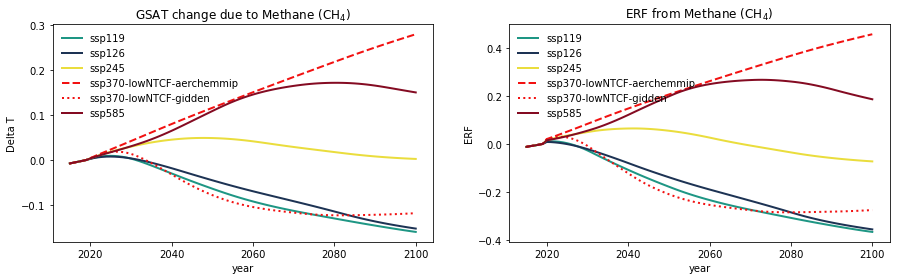

o3


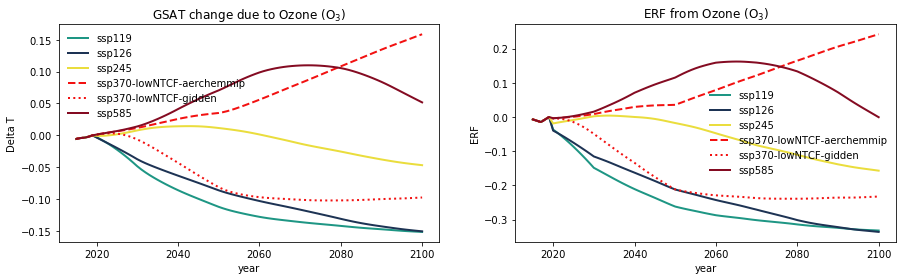

HFCs


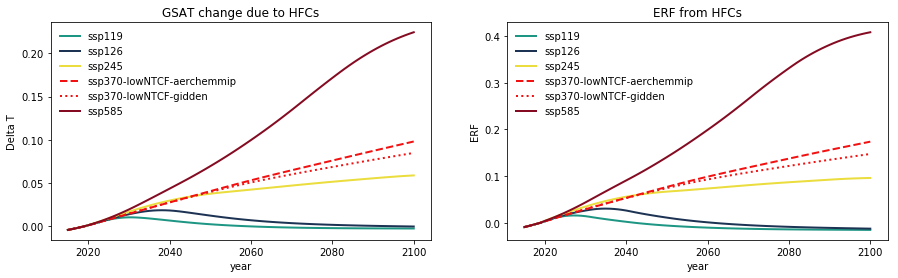

In [32]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_ls_dic, get_scenario_c_dic

# Get linestyle scenarios:
lsdic = get_scenario_ls_dic()  # get_ls_dic(ds_DT[climatemodel].values)

s_y = ref_year
s_y2 = '2015'
e_y = last_y
e_y2 = last_y
# Get colorscheme scenarios
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[15, 4])
    for scn in scenarios_fl:  # ) - {'historical'}):
        first = True
        _da1 = ds_DT[name_deltaT].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT[name_deltaT].sel(
            variable=var, scenario=scn,
            year=slice(s_y, s_y)).squeeze()
        _da1 = _da1.sel(percentile=recommendation)
        _da2 = ds_DT['ERF'].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2)) - ds_DT['ERF'].sel(variable=var,
                                                                                                       scenario=scn,
                                                                                                       year=slice(s_y,
                                                                                                                  s_y)).squeeze()
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da  # .sel(percentile='median')#.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle=lsdic[scn], linewidth=2)
    print(var)

    axs[0].set_title('GSAT change due to %s' % get_var_nicename(var))
    axs[1].set_title('ERF from %s' % get_var_nicename(var))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()